In [2]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import minimize

data/13_102.5_104.5_0.1.npy [1, 1]


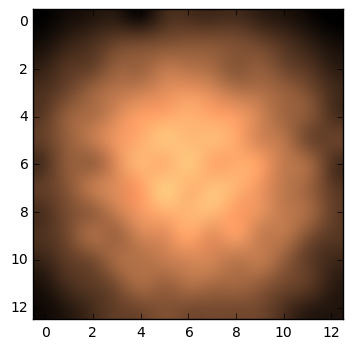

data/15_216_220_0.2.npy [[1, 2], [2, 1]]


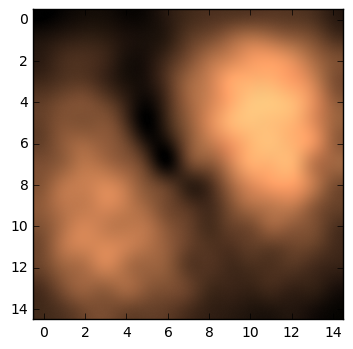

data/15_314.5_318.5_0.2.npy [2, 2]


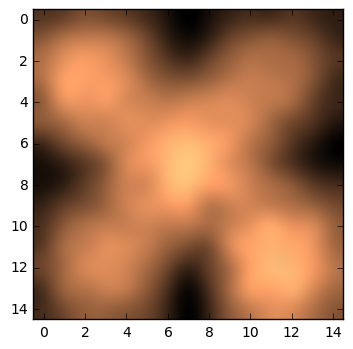

data/13_370_400_0.5.npy [1, 3]


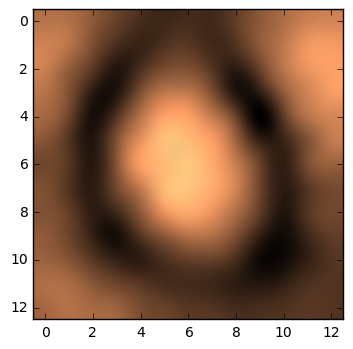

data/13_490_496_0.2.npy [[2, 3], [3, 2]]


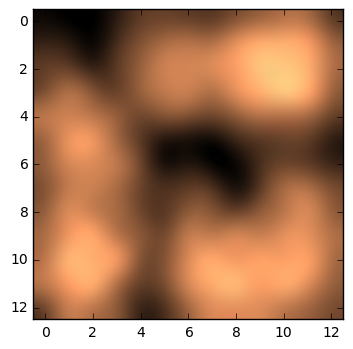

data/15_646_650_0.2.npy [3, 3]


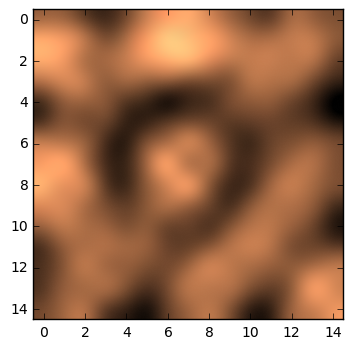

data/15_710_718_0.2.npy [[2, 4], [4, 2]]


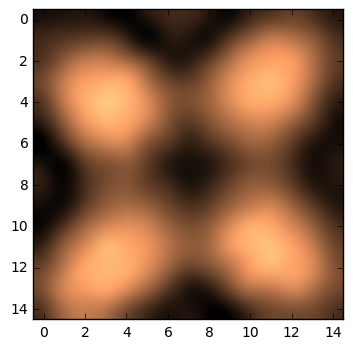

data/15_900_905_0.2.npy [[1, 5], [5, 1]]


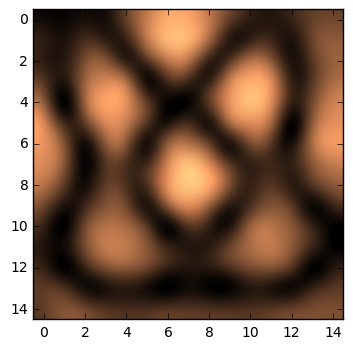

data/15_1138_1158_0.3.npy [[3, 5], [5, 3]]


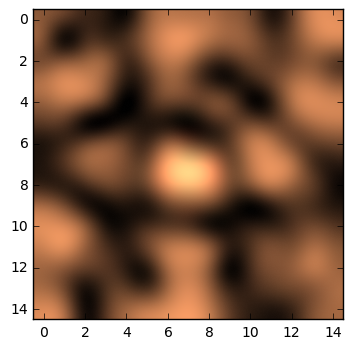

In [3]:
good_maps = [
    'data/13_102.5_104.5_0.1.npy',
    'data/15_216_220_0.2.npy',
    'data/15_314.5_318.5_0.2.npy',
    'data/13_370_400_0.5.npy',
    'data/13_490_496_0.2.npy',
    'data/15_646_650_0.2.npy',
    'data/15_710_718_0.2.npy',
    'data/15_900_905_0.2.npy',
    'data/15_1138_1158_0.3.npy'
]
eigenmodes = [
    [1, 1], #102
    [[1, 2], [2, 1]], #216
    [2, 2], #314
    [1, 3], #370
    [[2, 3], [3, 2]], #490
    [3, 3], #646
    [[2, 4], [4, 2]],#710 
    [[1, 5], [5, 1]],#900
    [[3, 5], [5, 3]]#1138
]

Here are all the eigenmode functions:

In [ ]:
eigenmode_function = []
eigenmode_function.append(lambda x: 0.75*(np.cos(x)+.333*np.cos(3*x)))
eigenmode_function.append(lambda x: 0.667*(np.sin(2*x)+.5*np.sin(4*x)))
eigenmode_function.append(lambda x: 0.625*(np.cos(3*x)+.6*np.cos(5*x)))
eigenmode_function.append(lambda x: 0.6*(np.sin(4*x)+0.667*np.sin(6*x)))
eigenmode_function.append(lambda x: 0.583*(np.cos(5*x)+.71429*np.cos(7*x)))